# Convolutional 2D VAE

Import necessary packages

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape

## Data Input and Pre Processing

Define core features of the dataset

In [32]:
dim = 2
numpart = 30
latent_dim = 50
box_size = 10

Import and reshape data

In [15]:
fname = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_30_10_1_0.75_0.2_10000_2500_5_x.txt'
#fname = '/Users/lorenzobarbiero/Documents/GitHub/variational-autoencoders/mc-sampling/good-runs/test_30_10_1_0.75_0.2_10000_2500_5_x.txt'

with open(fname) as f:
    df0 = pd.DataFrame( [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""] )
    
fname1 = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_30_10_0.1_0.75_0.2_10000_2500_0_x.txt'

with open(fname1) as f:
    df1 = pd.DataFrame( [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""] )
    
data = pd.concat([df0, df1])
    
labels = np.array(  [0]*len(df0) + [1]*len(df1)  )

In [16]:
np.array(data)

array([[7.71523 , 3.156986, 5.357889, ..., 3.612328, 7.88783 , 0.094937],
       [9.886406, 1.733028, 5.70476 , ..., 2.687815, 6.587482, 3.315774],
       [7.872951, 3.379019, 6.314323, ..., 5.287377, 3.631277, 1.200194],
       ...,
       [3.019755, 0.356259, 1.615354, ..., 2.017166, 7.702467, 1.62207 ],
       [3.360621, 2.956533, 8.538284, ..., 2.691005, 6.054854, 7.610028],
       [9.059092, 1.238999, 7.451033, ..., 5.941094, 4.180046, 1.930335]])

In [17]:
vcs = np.array(data).reshape((-1,numpart,dim))/(box_size*np.sqrt(dim))
print(vcs.shape,vcs[1])

(20000, 30, 2) [[0.69907447 0.12254359]
 [0.40338745 0.1792725 ]
 [0.20082709 0.16623486]
 [0.12481375 0.04370966]
 [0.29350977 0.12561109]
 [0.01936327 0.17822626]
 [0.15290413 0.11070697]
 [0.59667275 0.00867493]
 [0.05488492 0.09542703]
 [0.54395476 0.07950857]
 [0.25255676 0.22815755]
 [0.36184047 0.02877175]
 [0.38732934 0.25816143]
 [0.53847065 0.24678925]
 [0.19610093 0.01433829]
 [0.45404627 0.07791192]
 [0.01615626 0.03062055]
 [0.50822515 0.01089439]
 [0.38795378 0.1017096 ]
 [0.67271742 0.05074997]
 [0.2252128  0.0924284 ]
 [0.09787263 0.17063272]
 [0.69857462 0.24034369]
 [0.55481345 0.15300765]
 [0.2823389  0.03415609]
 [0.62316126 0.10113289]
 [0.47584878 0.14973842]
 [0.33143276 0.20466336]
 [0.62062196 0.19005722]
 [0.46580532 0.23446063]]


Sort by distance from origin

In [18]:
sortmode = 1
if sortmode==1:

    # Calculate distances from (0, 0)
    distances = np.sqrt(vcs[:,:,0]**2 + vcs[:,:,1]**2)
    idx = np.argsort(distances, axis=1)
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]

    print(sorted_vcs.shape,"\n",sorted_vcs[1])

(20000, 30, 2) 
 [[0.01615626 0.03062055]
 [0.05488492 0.09542703]
 [0.12481375 0.04370966]
 [0.01936327 0.17822626]
 [0.15290413 0.11070697]
 [0.19610093 0.01433829]
 [0.09787263 0.17063272]
 [0.2252128  0.0924284 ]
 [0.20082709 0.16623486]
 [0.2823389  0.03415609]
 [0.29350977 0.12561109]
 [0.25255676 0.22815755]
 [0.36184047 0.02877175]
 [0.33143276 0.20466336]
 [0.38795378 0.1017096 ]
 [0.40338745 0.1792725 ]
 [0.45404627 0.07791192]
 [0.38732934 0.25816143]
 [0.47584878 0.14973842]
 [0.50822515 0.01089439]
 [0.46580532 0.23446063]
 [0.54395476 0.07950857]
 [0.55481345 0.15300765]
 [0.53847065 0.24678925]
 [0.59667275 0.00867493]
 [0.62316126 0.10113289]
 [0.62062196 0.19005722]
 [0.67271742 0.05074997]
 [0.69907447 0.12254359]
 [0.69857462 0.24034369]]


### Compute distance matrices

In [19]:
dm = np.zeros((len(vcs),numpart,numpart))

for i in range(len(vcs)):
               dm[i]=squareform(pdist(sorted_vcs[i], metric='euclidean'), force='no', checks=True)
               
print(dm.shape, '\n', dm[1])

(20000, 30, 30) 
 [[0.         0.07549695 0.10944302 0.14764055 0.15847339 0.18067982
  0.16211407 0.21800195 0.22911691 0.26620612 0.29316919 0.30806828
  0.34568916 0.36012521 0.37853276 0.41478355 0.44043631 0.43536686
  0.47487502 0.49246413 0.49369531 0.53005782 0.55238589 0.56527978
  0.58093116 0.61108678 0.62513906 0.65686966 0.68907701 0.71391779]
 [0.07549695 0.         0.08697544 0.09009717 0.09920304 0.16284148
  0.0866247  0.17035427 0.16221241 0.23556197 0.24052629 0.23809987
  0.31410927 0.29734035 0.33312811 0.35844675 0.39954545 0.37013751
  0.42445294 0.46115413 0.43380401 0.48932883 0.5032336  0.50672052
  0.54868933 0.56830498 0.57359679 0.61944575 0.64476002 0.65980093]
 [0.10944302 0.08697544 0.         0.17092255 0.07264784 0.07710084
  0.12975086 0.11159518 0.14418895 0.15781458 0.1875265  0.22436421
  0.23749696 0.26191126 0.26945625 0.30980734 0.3310043  0.33897492
  0.36669836 0.38481313 0.3907188  0.42066703 0.44367306 0.46081813
  0.47315785 0.50164496 0.51

Split in training and test set

In [20]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [28]:
train_perc=0.8

m = sorted_vcs.shape[0]
print(m)
permutation = np.random.permutation(m) # random permurtation

sorted_vcs = sorted_vcs[permutation]
labels = labels[permutation]
dm = dm[permutation]

#m_training needs to be the number of samples in the training set
m_training = int(m*train_perc)

#m_test needs to be the number of samples in the test set
m_test = m-m_training

trainset_conf = sorted_vcs[:m_training]
testset_conf = sorted_vcs[m_training:]

trainset_mat = dm[:m_training]
testset_mat = dm[m_training:]


#check if there are at least 10 elements from class -1 and 1
c1=np.count_nonzero(labels[:m_training]==1)
c0=np.count_nonzero(labels[:m_training]==0)

print('number of 1 in training set:', c1, '\n', 'number of 0 in training set:', c0)

while(c1<1000 or c0<1000): #permute until the condition is reached
    
    permutation = np.random.permutation(m) # random permurtation
    
    sorted_vcs = sorted_vcs[permutation]
    labels = labels[permutation]
    dm = dm[permutation]
    
    trainset_conf = sorted_vcs[:m_training]
    testset_conf = sorted_vcs[m_training:]
    
    trainset_mat = dm[:m_training]
    testset_mat = dm[m_training:]
    
    c1=np.count_nonzero(labels[:m_training]==1)
    c0=np.count_nonzero(labels[:m_training]==0)
    

print("Shape of training set: " + str(trainset_conf.shape))
print("Shape of test set: " + str(testset_mat.shape))

20000
number of 1 in training set: 8001 
 number of 0 in training set: 7999
Shape of training set: (16000, 30, 2)
Shape of test set: (4000, 30, 30)


## Variational Auto Encoder (Model 1)

### Sampling class

In [33]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [34]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
#x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = Flatten()(x) #Flatten


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 30, 30, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 57600)        0           ['conv2d_3[0][0]']               
                                                                                            

### Decoder

In [35]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
#x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
decoder_outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = keras.Model(decoder_input, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 dense_1 (Dense)             (None, 57600)             2937600   
                                                                 
 reshape_1 (Reshape)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 30, 30, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 30, 30, 1)        289 

### VAE Class

In [36]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            size = reconstruction.shape[1:]  # Extract dimensions excluding the first 'None' dimension
            noise = np.random.normal(0, 0.1, size=size)
            reconstruction = reconstruction + noise
            
            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [37]:
reg_lambda=0.001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) #lower learning rate
fit=vae.fit(trainset_mat, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
125/125 - 98s - loss: 0.0150 - reconstruction_loss: 0.0143 - kl_loss: 0.6447 - 98s/epoch - 784ms/step
Epoch 2/10
125/125 - 88s - loss: 0.0102 - reconstruction_loss: 0.0098 - kl_loss: 0.4140 - 88s/epoch - 704ms/step
Epoch 3/10
125/125 - 88s - loss: 0.0081 - reconstruction_loss: 0.0074 - kl_loss: 0.7417 - 88s/epoch - 701ms/step
Epoch 4/10
125/125 - 89s - loss: 0.0070 - reconstruction_loss: 0.0061 - kl_loss: 0.8932 - 89s/epoch - 711ms/step
Epoch 5/10
125/125 - 89s - loss: 0.0066 - reconstruction_loss: 0.0057 - kl_loss: 0.9100 - 89s/epoch - 713ms/step
Epoch 6/10
125/125 - 89s - loss: 0.0064 - reconstruction_loss: 0.0054 - kl_loss: 0.9257 - 89s/epoch - 713ms/step
Epoch 7/10
125/125 - 90s - loss: 0.0061 - reconstruction_loss: 0.0051 - kl_loss: 0.9767 - 90s/epoch - 718ms/step
Epoch 8/10
125/125 - 89s - loss: 0.0058 - reconstruction_loss: 0.0048 - kl_loss: 1.0518 - 89s/epoch - 712ms/step
Epoch 9/10
125/125 - 90s - loss: 0.0056 - reconstruction_loss: 0.0045 - kl_loss: 1.1018 - 90s/ep

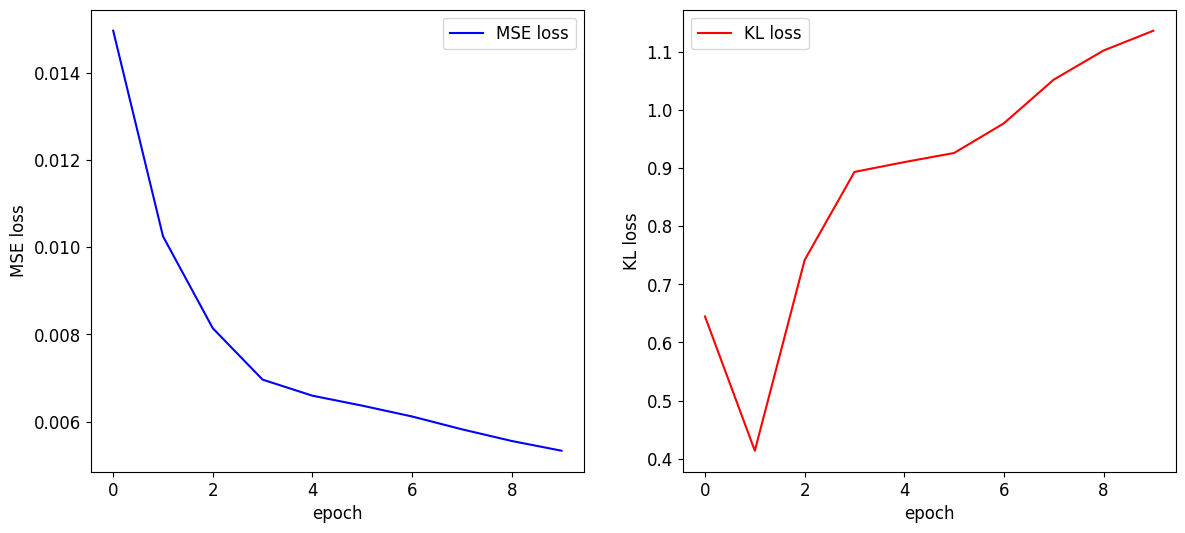

In [38]:
plt.rcParams['font.size'] = 12
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [39]:
encoded_test = np.array(vae.encoder.predict(testset_mat))
encoded_train = np.array(vae.encoder.predict(trainset_mat))

500/500 [==============================] - 13s 25ms/step


In [40]:
print(encoded_test.shape)

(3, 4000, 50)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [41]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(4000, 50)


Sampling in the latent space is reasonably gaussian as expected

In [43]:
#df = pd.DataFrame(dim1, columns=["x", "y"])
#sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [44]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,numpart,numpart)
decoded_train = np.array(decoder.predict(encoded_train[2,:,:])).reshape(-1,numpart,numpart)
print(decoded_test.shape)

500/500 [==============================] - 24s 48ms/step
(4000, 30, 30)


### Check reconstruction

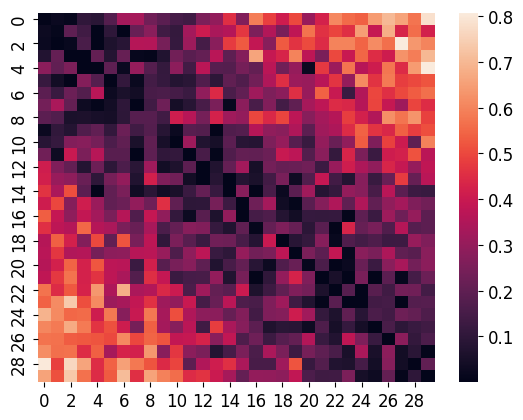

In [45]:
ind = 20
df = pd.DataFrame(decoded_test[ind])
sns.heatmap(data=df);

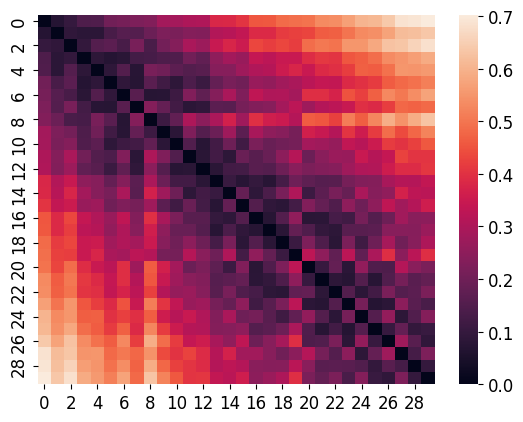

In [46]:
df2 = pd.DataFrame(testset_mat[ind])
sns.heatmap(data=df2);

## Coordinates Reconstructor (Model 2)
The reconstructor is trained on the original distance matrices and predicts the decoded matrices

In [47]:
rec_inputs = layers.Input(shape=(numpart,numpart))
x = Flatten()(rec_inputs)
x = layers.Dense(int(numpart**2 *4/5), activation='relu')(x)
x = layers.Dense(int(numpart**2 *3/5), activation='relu')(x)
x = layers.Dense(int(numpart**2 *2/5), activation='relu')(x)
x = layers.Dense(int(numpart**2 *1/5), activation='relu')(x)
x = layers.Dense(int(numpart*dim))(x)
rec_outputs = Reshape((numpart, dim))(x)
reconstruction = keras.Model(rec_inputs,rec_outputs)
reconstruction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 900)               0         
                                                                 
 dense_2 (Dense)             (None, 720)               648720    
                                                                 
 dense_3 (Dense)             (None, 540)               389340    
                                                                 
 dense_4 (Dense)             (None, 360)               194760    
                                                                 
 dense_5 (Dense)             (None, 180)               64980     
                                                                 
 dense_6 (Dense)             (None, 60)                10860 

In [48]:
reconstruction.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredError()) #lower learning rate
fit=reconstruction.fit(trainset_mat, trainset_conf, epochs=30, batch_size=128, verbose=2)

Epoch 1/30
125/125 - 3s - loss: 0.0259 - 3s/epoch - 27ms/step
Epoch 2/30
125/125 - 3s - loss: 0.0132 - 3s/epoch - 22ms/step
Epoch 3/30
125/125 - 3s - loss: 0.0125 - 3s/epoch - 25ms/step
Epoch 4/30
125/125 - 4s - loss: 0.0121 - 4s/epoch - 28ms/step
Epoch 5/30
125/125 - 3s - loss: 0.0118 - 3s/epoch - 27ms/step
Epoch 6/30
125/125 - 4s - loss: 0.0116 - 4s/epoch - 29ms/step
Epoch 7/30
125/125 - 3s - loss: 0.0114 - 3s/epoch - 25ms/step
Epoch 8/30
125/125 - 3s - loss: 0.0112 - 3s/epoch - 24ms/step
Epoch 9/30
125/125 - 3s - loss: 0.0111 - 3s/epoch - 23ms/step
Epoch 10/30
125/125 - 3s - loss: 0.0109 - 3s/epoch - 24ms/step
Epoch 11/30
125/125 - 3s - loss: 0.0108 - 3s/epoch - 24ms/step
Epoch 12/30
125/125 - 3s - loss: 0.0106 - 3s/epoch - 24ms/step
Epoch 13/30
125/125 - 3s - loss: 0.0105 - 3s/epoch - 23ms/step
Epoch 14/30
125/125 - 3s - loss: 0.0104 - 3s/epoch - 23ms/step
Epoch 15/30
125/125 - 3s - loss: 0.0103 - 3s/epoch - 22ms/step
Epoch 16/30
125/125 - 3s - loss: 0.0102 - 3s/epoch - 23ms/step
E

In [49]:
rec_test = np.array(reconstruction.predict(testset_mat))
rec_test_dec = np.array(reconstruction.predict(decoded_test))


125/125 [==============================] - 1s 4ms/step


### Evaluate performance
Original data is in blue, reconstructed original configurations in gold

(-0.15, 1.15)

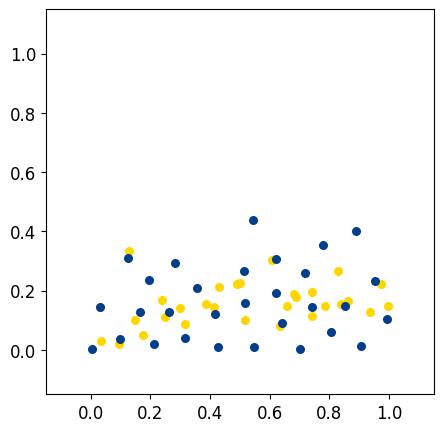

In [54]:
ind=20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(rec_test[ind,:,0]*l, rec_test[ind,:,1]*l, s=30, c="gold")
ax.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=30, c="#023e8a")
ax.set_xlim(-0.15,1.15)
ax.set_ylim(-0.15,1.15)

Original data is in 

(-0.15, 1.15)

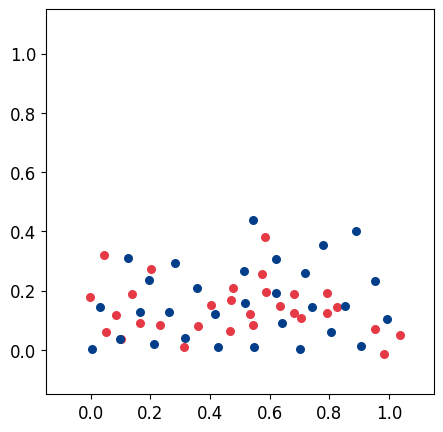

In [55]:
ind=20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(rec_test_dec[ind,:,0]*l, rec_test_dec[ind,:,1]*l, s=30, c="#e63946")
ax.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=30, c="#023e8a")
ax.set_xlim(-0.15,1.15)
ax.set_ylim(-0.15,1.15)

MovieWriter imagemagick unavailable; using Pillow instead.


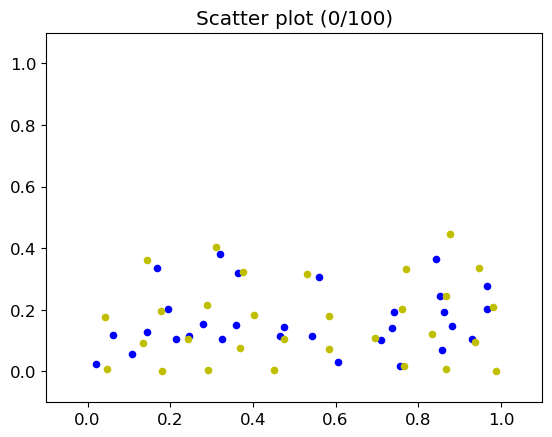

In [29]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100

# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(rec_test[ind,:,0]*l, rec_test[ind,:,1]*l, s=20, c="b")
    plt.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=20, c="y")
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)

# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=400)

# Save the animation as a GIF
animation.save("conv2dist.gif", writer="imagemagick")

## Deez Labels

In [63]:
import sklearn
from sklearn.decomposition import PCA

def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ =  vae.encoder.predict(data)
   

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(z_mean)
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)
    
    #plot
    plt.figure(figsize=(5, 5))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

625/625 [==============================] - 12s 20ms/step
[0.05030514 0.03112051]


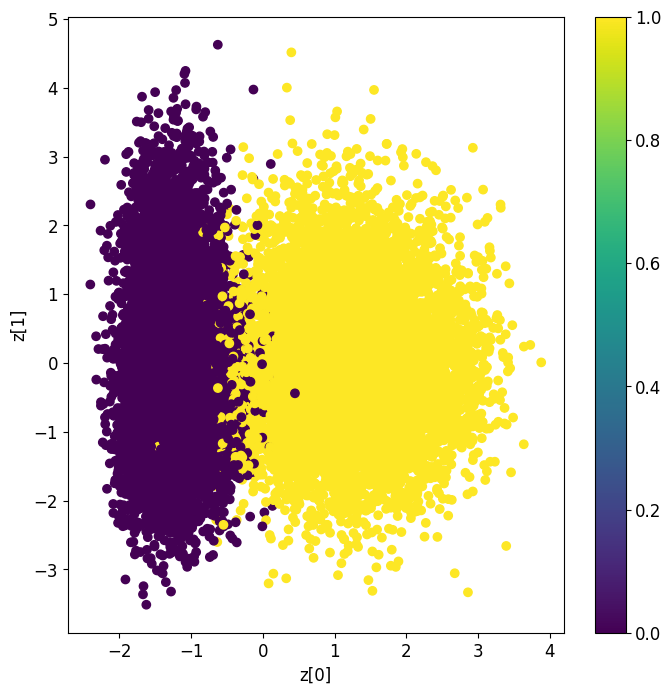

In [64]:
label_vis(vae, dm, labels)